# Image Classfication - Transfer learning on Food 101 Dataset (EfficientNetV2S)

Utilizing Transfer Learning Feature extracton a multiclass classficiation model will be generated on Food-101 Image Dataset. We'll also fine tune the model in order to generate more suitable trained parameters for our dataset.





## EfficientNetV2S


EfficientNetV2S is an optimized convolutional neural network (CNN) model that is trained on ImageNet(21-k). Reason for using this for our purposes is that it utilizes quarter of the parameters in comparision to other model e.g. ResNet while generating comparable Top 1% accuracy. The reduction in paramters translates to a significant improvement in training time.

[Image Reference](https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2)

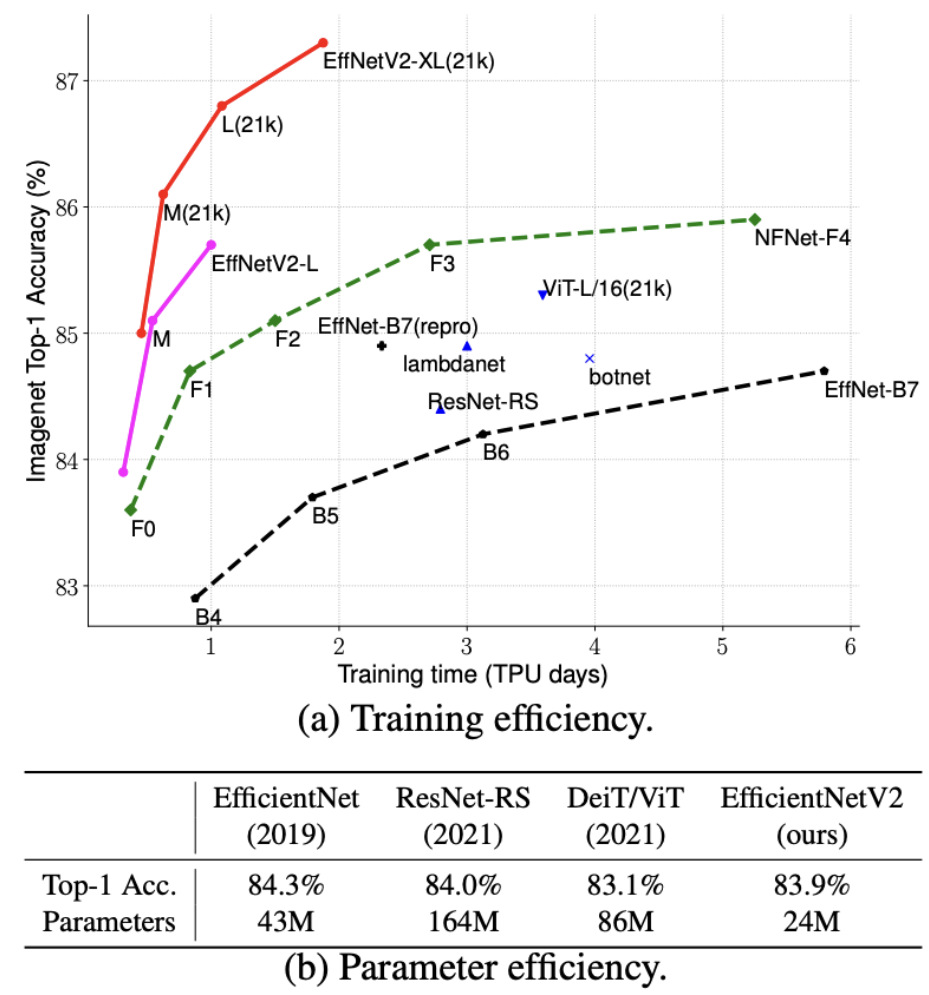

## Pre-Setup

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import os
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

In [2]:
tf.__version__

'2.8.2'

Vitrual Machine (VM) with a higher RAM is being used in order to utilize higher network throughput and image preprocessing capabilities. VM RAM is not utilized in our case as GPU and its corresponding memory will be used. But due to the VM configuaration, a VM with a higher RAM provides more CPU cores and increased network throughput. 

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


Google Colab Pro+ subscription google provides Tesla P100. Though considered top of the line, it still hampers in faster training times due to the uncompatibility with mixed-precision training. 

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 14 03:53:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Food 101 - Dataset



[Food 101 - Dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) consists of 101,100 images consisting of 101 classes of different food images. Initally the authors utilized Random Forests to classify the images and generated [50.76%](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) validation accuracy. As it is an image dataset CNN are best suited to extract features from the images and hopefully improve results. The dataset is balanced with 750 training images and 250 validation images per class. 

For our purposes the dataset has been downloaded from [TensorFlow Website](https://www.tensorflow.org/datasets/catalog/food101). Split in train and validation data is exactly the same as the original dataset. This would help us compare our results with the original data. In case of train data it is a good practice to shuffle it as it prevents the model generating a bias towards a speicific class during training. Validation data does not require to be shuffled as no data is utilized from it during training.

In [5]:
# Data Import from Tensorflow

import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

(train_data, test_data), ds_info = tfds.load(name = "food101", split = ["train", "validation"],
                                             shuffle_files = True, as_supervised = True, # Tuple format (data, label)
                                             with_info = True) # Include Metadata

True


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteWVLY5E/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteWVLY5E/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Data Visualization

Sample images from different classes have been extracted for visualization purposes. Many images exhibit redundant features (noise) in the dataset i.e utensiles, plates and in some humans. Additionally, some images have been misclassified as well. This will certainly create difficulties for the model to compute weights and biases representative of the classes. 

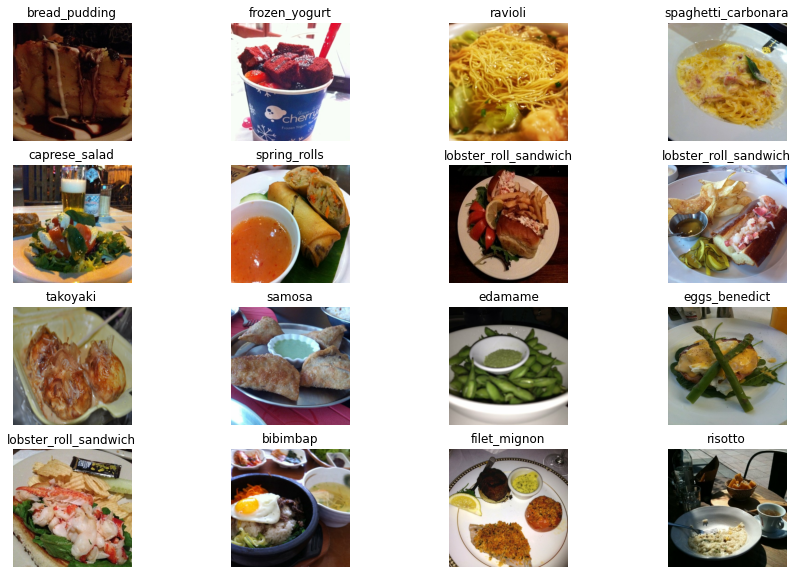

In [6]:
from tensorflow.python.ops.gen_image_ops import resize_area
class_names = ds_info.features["label"].names
sample_images = train_data.take(16)
image_set = []
label_set = []
image_set_resized = []
for images, labels in sample_images:
  image_set.append(images)
  label_set.append(labels)

from tensorflow.python.ops.gen_image_ops import resize_area
for i in image_set:
  resize = tf.image.resize(i, [384,384])
  resize = resize/255.0
  image_set_resized.append(resize)

plt.figure(figsize = (15,10))
for i in range(16):
  ax = plt.subplot(4,4, i + 1)
  plt.title(class_names[label_set[i]])
  plt.imshow(image_set_resized[i])
  plt.axis(False)

In [7]:
#@title 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

def data_unzip(zip_file_name):
  import zipfile
  zip_ref = zipfile.ZipFile(zip_file_name)
  zip_ref.extractall()
  zip_ref.close()
data_unzip("101_food_classes_10_percent.zip")
test_dir = "101_food_classes_10_percent/test/"

valid_data_test = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   label_mode = "int",
                                                                   batch_size = 32,
                                                                   image_size = (384,384),
                                                                   shuffle = False,
                                                                   class_names = class_names)

--2022-08-14 03:59:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.28.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   292MB/s    in 5.4s    

2022-08-14 03:59:35 (289 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

Found 25250 files belonging to 101 classes.


Images in the dataset are of **.JPG** format. When imported into Colab, each image is converted to a 3-Dimensional tensor where each pixel of the image has a RGB representation between (0 and 255). All images consist of different sizes (pixel counts) and uneven dimensions. Th min resolution for either width/height is 221 and maximum is 512

Food_101 Dataset Metadata: FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})



Image Shape: (512, 512, 3)
Image Datatype: <dtype: 'uint8'>
Target Class from Food101 (categorical): 64
Class name (str form): miso_soup


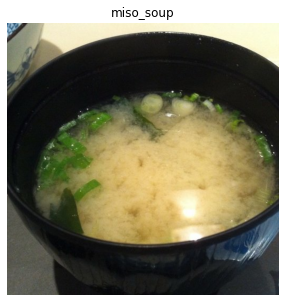

In [9]:
# Single Sample
train_data_one_sample = train_data.take(1)
for image, label in train_data_one_sample:
  image = image

print(f"""Food_101 Dataset Metadata: {ds_info.features}\n


Image Shape: {image.shape}
Image Datatype: {image.dtype}
Target Class from Food101 (categorical): {label}
Class name (str form): {class_names[label.numpy()]}""")

plt.figure(figsize = (8,5))
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()

When converted to a tensor, the datatype is **uint8**. For purposes of GPU computation, the datatype needs to be changed to float16/32 or in case of TPU bloat16.

In [10]:
# Sample converted into a tensor 3D tensor
one_image = image
print(f"Class name (str form): {class_names[label.numpy()]}")
print(f"Tensor Min value: {tf.reduce_min(one_image)}, Tensor Max value: {tf.reduce_max(one_image)}")
print(one_image)

Class name (str form): miso_soup
Tensor Min value: 0, Tensor Max value: 255
tf.Tensor(
[[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 45  89 124]
  [ 52  96 131]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 ...

 [[ 91  99  86]
  [ 89  97  84]
  [ 88  94  82]
  ...
  [ 37  44  50]
  [ 34  41  47]
  [ 31  38  44]]

 [[ 91  99  86]
  [ 90  98  85]
  [ 88  96  83]
  ...
  [ 38  43  47]
  [ 35  40  44]
  [ 33  38  42]]

 [[ 93 101  88]
  [ 93 101  88]
  [ 89  97  84]
  ...
  [ 37  42  46]
  [ 35  40  44]
  [ 35  40  44]]], shape=(512, 512, 3), dtype=uint8)


## Data Preprocessing

Data preprocessing is essenatial for CNNs and espcially in the case of transfer learning. Due to the fact that the models have been trained on specific specifications. The following preprocessing measures have been done:

--- 

1. Data Type Conversion: When data was imported it was converted to uint8. Most models utilize float32 dtype for computations. For our purposes data has been converted to float32. Advances in GPU technology has enabled mixed precision training where layers in CNN can be be a mixture of Float16/32. This enables faster computations while retaining numeric stability during training. Mixed precision conversion is possible in EfficientNet but requries the GPU to have a compute capability of [7.0+](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/mixed_precision.ipynb). In our case [NVIDIA P100](https://developer.nvidia.com/cuda-gpus) has a score of 6.0 hence mixed precision would not be possible.

2. Image Resizing: [EfficentNetV2-S](https://colab.research.google.com/github/google/automl/blob/master/efficientnetv2/tfhub.ipynb#scrollTo=FlsEcKVeuCnf) has been trained on ImageNet with an image map of 384 where 384 is the width and height of an image. Kernal size, shifts and padding for EfficientNetV2-S have also been designed keeping the dimensions mentioned above in mind. The weights and biases for feature maps have been computed according to these dimensions. Keeping this in view each image of Food-101 dataset has been resized to resolution of (384 x 384).

3. Batch Conversion: All images in both test and validation sets will be coalesced into minibatches. This is due to the fact that minibathces decrease the load on GPU memory when the model is trained. Rather than loading all 75,750 training images all at one in the GPU, a smaller batch is ingested in steps during each epoch. Additionally, batch conversion enhances the learned feature representations (weights and biases computation) as the representations are adjusted in more steps in a single epoch rather than one adjustment in a single epoch. The test errors are also improved with minibatch computations. As suggested by Professor [Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?lang=en) a batch size of 32 will be used. 

4. Parallelization: Immense computing power is required to convert data into batches and ingesting them into the model during each epoch takes a significant amount of time. To avoid this a [pipline](https://www.tensorflow.org/guide/data_performance) has been mapped where images will be prefethced and converted into batches by the CPU before being utilized by the GPU. This reduces the load on the GPU and results in faster computations. Moreover, multi-core CPUs will also work in parallel to prefetch and convert images. Buffer size will be 1000 where one thousand images will be prefetched, shuffled and convert into batches of size 32.

4. Normalization: Each tensor value in the dataset has been to be scaled to be between 0 and 1. Normalization increases the efficiency of the computations and makes the optimizer (Adam in our case) to reach a global minima more quickly. EfficientNets in general have a normalization layer built in, hence it would not need to be done prior but a sample tensor shown below represents how a normalized tensor would look like. 




In [11]:
# Custom Preprocessing function 
def preprocess_img(image, label, img_shape = 384, scale_img = False):
  """
  Conversion of image from uint8 to float32 and 
  reshaping of image to [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape]) # Conversion of image size
  boolean = scale_img
  if boolean == True: # Scaling if required for certain models
    image = image/255.0 # Scaling
    return tf.cast(x = image, dtype = tf.float32), label # Conversion to float32
  else:
    return tf.cast(x = image, dtype = tf.float32), label # Conversion to float32

Preprocesses Sample Tensor

In [12]:
# Sample of preprocesses image 
preprocessed_img = preprocess_img(one_image, label, img_shape = 384 ,scale_img=False)[0]
print(f"Image before preprocessing:\n {one_image[:2]}..., \nShape: {one_image.shape}, \nDatatype: {one_image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 44.38889   90.05555  125.888885]
  [ 69.166664 112.666664 147.16667 ]
  [117.833336 157.50002  189.00002 ]
  ...
  [251.       254.       223.      ]
  [250.5      253.5      222.5     ]
  [250.       253.       222.      ]]

 [[ 45.        89.83333  125.25    ]
  [ 72.25     115.75     150.25    ]
  [124.08334  163.75     195.25    ]
  ...
  [251.       254.       223.      ]
  [250.5      253.5      222.5     ]
  [250.       253.       222.      ]]]...,
Shape: (384, 384, 3), 
Datatype: <dtype: 'float32'>


In [13]:
# Data conversion to batches with shuffling and parallelization enabled


# Mapped preprocessing and parallelized (train data)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
# Train data shuffled and turned into batches. Plus prefetched (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)



# Mapped preprocessing to test data (shuffling not required for test dataset)
valid_data = test_data.map(preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

Final Batch Representation

In [14]:
train_data, valid_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Callbacks

Callbacks are extra functionalities that can be added during model training. For our accessibility three callbacks are being used.

1. TensorBoard Callback: During training at each epoch model evaluation metrics e.g. loss and accuracy will be stored automatically to TensorBoard Hub. 

2. Checkpoint Callback: During each epoch, model parameters i.e. the weights and biases will be monitored. Learned representations of with the lowest validation accuracy will be saved to google drive. 

3. EarlyStopping Callback: To avoid overfitting of the model validation accuracy will be monitored. If the validation accuracy does not improve after 3 consecutive epochs (Patience), the model will stop learning. 

**Note: Preventing model overfit creates the model more generalizable. Generalization helps the model predict unseen data more accurately and increases the validation accuracy.**



In [15]:
# Creating callbacks while our model trains

# Tensorboard Callback
def create_tensorboard_callback(dir_name, experiment_name):
  import datetime
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

# Model checkpoint callbacks
checkpoint_path = "/content/drive/MyDrive/tfexperiments/model_checkpoints/model_1.ckpt"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor = "val_accuracy",
                                                       save_best_only = True,
                                                       save_weights_only = True,
                                                       verbose = 1)

# Early Stopping Callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode = "max")

## Model-1 Transfer learning feature extraction 

Feature extraction model has been built using the Keras sequential API. Input layer shape is (384 ,384 ,3) i.e. (Width, Height, Color Channels). The base model (EfficientNetV2-S) is frozen and no training will be performed on the base model layers. The GlobalAveragePooling2D layer converts computes tensors from the base model layers into a feature vector. The feature vector is fully connected to a Dense layer (output layer) which has 101 neurons i.e. One neuron for each class. Only this layer will be trainable. For each tensors output there will be probability vector due to the softmax activation function. The vector for an individual image will belong to the class of the highest probability.

During compilation the loss function would be Sparse Categorical CrossEntropy as the true data labels are categorical and not one hot encoded. The optimizer will be Adam with the default learning rate of 0.001. This learning rate can be adjusted utilizing the learning rate callback but in case of a large dataset using the defualt learning rate is recommended such the step size is larger and the loss is able to reach the global minima at a faster rate. Validation accuracy will be the evaluation metric for the model. The reason for using accuracy is becuase there are a balanced number of classes and it would also be measure to evaluate how close the predictions are to their true values.

❗ Due to computational constraints the model will be trained for 20 epochs only and results will be evaluated. 

In [16]:
## Built feature extraction model

input_shape = (384,384,3) # Input Shape
base_model = tf.keras.applications.EfficientNetV2S(include_top = False, include_preprocessing = True) # Base Model 
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "Input Layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pooling_2D_layer")(x) 
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax")(x) # 101 Classes

model_1 = tf.keras.Model(inputs, outputs)

82436096/82420632 [==============================] - 1s 0us/step


In [17]:
# Compiled the model
model_1.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])

❗ As the base model is frozen there are only 129,381 trainable parameters and that too in the output layer.

In [18]:
# Model Summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_avg_pooling_2D_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 20,460,741
Trainable params: 129,381
Non-trainable params: 20,331,360
_________________________________________________________________


In [19]:
# Data type for each layer
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input Layer True float32 <Policy "float32">
efficientnetv2-s False float32 <Policy "float32">
global_avg_pooling_2D_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">


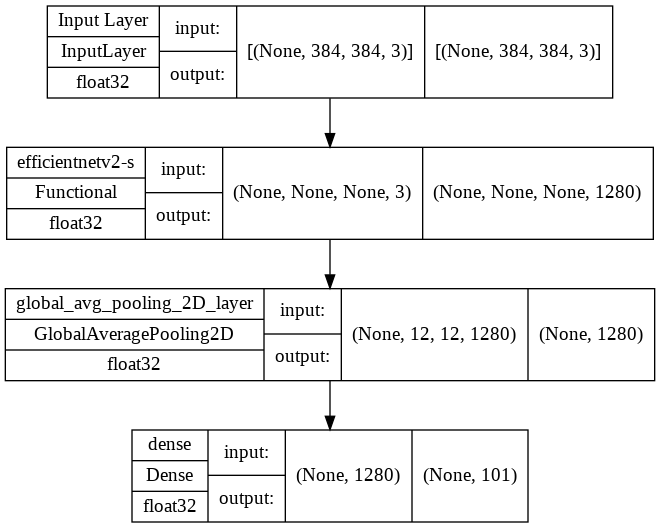

In [20]:
# Model Visualization
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes = True, show_dtype =True, show_layer_names = True)

In [21]:
# Model training 
checkpoint_path = "/content/drive/MyDrive/tfexperiments/model_checkpoints/model_1.ckpt"
history_101_model_1 = model_1.fit(train_data,
                                  epochs = 20,
                                  steps_per_epoch = len(train_data),
                                  validation_data = valid_data,
                                  validation_steps = len(valid_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "/content/drive/MyDrive/tfexperiments/training_logs",
                                                                           experiment_name = "efficientnetV2S_all_data_model_1"),
                                               model_checkpoints, early_callback])

Saving Tensorboard log files to: /content/drive/MyDrive/tfexperiments/training_logs/efficientnetV2S_all_data_model_1/20220814-040756
Epoch 1/20
2368/2368 [==============================] - ETA: 0s - loss: 1.5834 - accuracy: 0.6082
Epoch 1: val_accuracy improved from -inf to 0.72756, saving model to /content/drive/MyDrive/tfexperiments/model_checkpoints/model_1.ckpt
2368/2368 [==============================] - 594s 240ms/step - loss: 1.5834 - accuracy: 0.6082 - val_loss: 1.0269 - val_accuracy: 0.7276
Epoch 2/20
2367/2368 [============================>.] - ETA: 0s - loss: 1.1041 - accuracy: 0.7106
Epoch 2: val_accuracy improved from 0.72756 to 0.75743, saving model to /content/drive/MyDrive/tfexperiments/model_checkpoints/model_1.ckpt
2368/2368 [==============================] - 567s 239ms/step - loss: 1.1042 - accuracy: 0.7106 - val_loss: 0.9048 - val_accuracy: 0.7574
Epoch 3/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.9807 - accuracy: 0.7407
Epoch 3: val_accuracy 

### Results 



During training the highest validation accuracy was recorded was 0.7888 i.e. 78.8% of the values in the validation set were predicted accurately by the model.

Training loss and validation loss converged on five epochs. After that there was a divergence. Similar is the case with training and validation accuracy. This suggests that the model is starting to overfit on the training data. Again, overfitting means that the model is reading the training data too well but would perform badly on new/unseen data. Though EarlyStopping callback prevents that, there was a marginal increase in validation accuracy even after five epochs hence the model kept on training. Model stopped training at the sixteenth epoch as the validation accuracy declined three consecutive times. 

To avoid overfitting and achieving generalization we can use some of the following techniques:

1. Incorporating dropout layers between the convolutional layers.
2. Increasing the size of the training data.
3. Augmenting the training data so model sees different variations of same data for better training.
4. Incorporate EarlyStopping callback again in a newer model

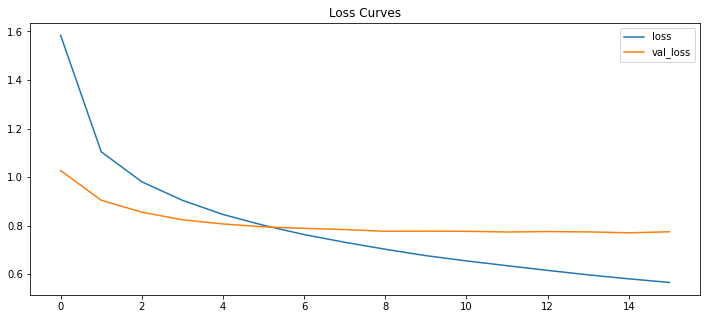

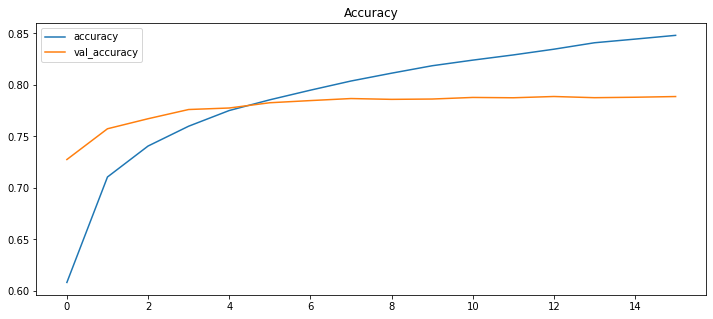

In [22]:
# Results visualization 
pd.DataFrame(history_101_model_1.history)[["loss", "val_loss"]].plot(figsize = (12,5), title = "Loss Curves")
pd.DataFrame(history_101_model_1.history)[["accuracy", "val_accuracy"]].plot(figsize = (12,5), title = "Accuracy")
plt.show()

## Model-2 Transfer learning feature extraction with data augmentation 


Model 2 is the same as Model 1 but for our purposes the model will be trained again from the beginning. To avoid overfitting, an augmentation layer has been added between the input layer and the base model. Iteration of the same data will added to the CNN model to make it learn more generalizable patterns. The original dataset itself will not change, rather additional modified data will be fed in to the model. Augmentations include flipping, zoom, width shift, height shift and rotation. These augmentations will be added randomly to the model. The images have been augmented marginally as extreme augmentation can lead to bizzare modification of photos, which do represent real life example. Too many augmentations or extreme augmentations leads to CNN learning unwanted patterns e.g. if we zoom in the photos too much or do a 180 degree rotation, CNN would not be able to learn the general shapes of the foods.

In [23]:
# Data augmentation layer incorprated right into the model

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.1),
    tf.keras.layers.RandomHeight(0.1),
    tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.Rescaling(1/255.0) # This layer already exists in efficientnet so not required to be put in 
], name = "data_augmentation_layer")

Augmentation on sample image

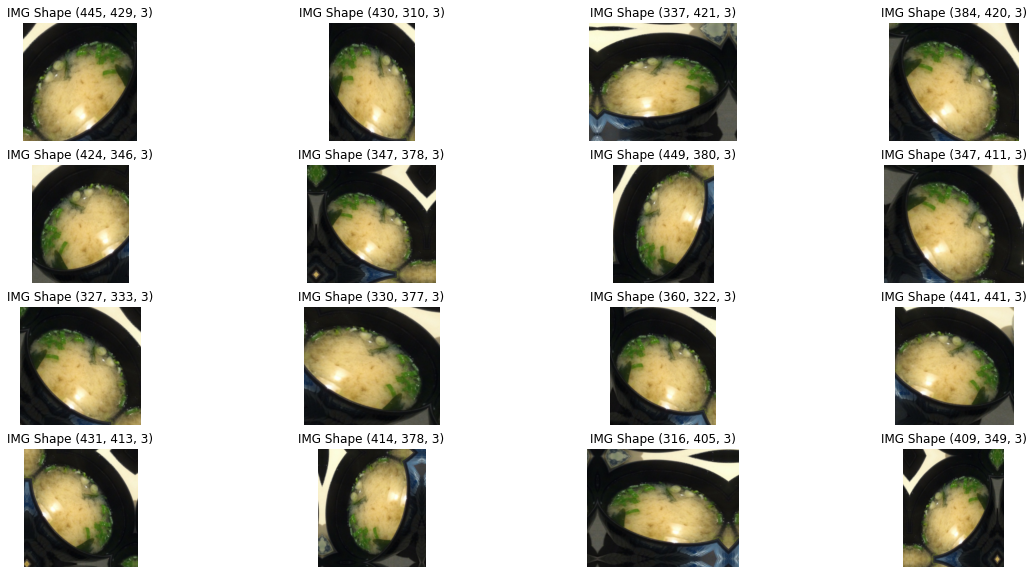

In [24]:
# Sample visualization of an augmented image 
def visualize_augmentation(image_sample):
  data_augmentation_sample = tf.keras.Sequential([
  tf.keras.layers.Resizing(384,384),
  tf.keras.layers.experimental.preprocessing.Rescaling(1/255.0),
  tf.keras.layers.RandomFlip(mode = "horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.1),
  tf.keras.layers.RandomWidth(0.1)], name = "data_augmentation")

  plt.figure(figsize=(20, 10))
  for i in range(16):
    augmented_image = data_augmentation_sample(image_sample, training = True)
    ax = plt.subplot(4, 4, i + 1)
    plt.title(f"IMG Shape {tf.squeeze(augmented_image).shape}")
    plt.imshow(augmented_image)
    plt.axis("off")

visualize_augmentation(image)

In [25]:
# Fitted the model 
input_shape = (384,384,3)
base_model_2 = tf.keras.applications.EfficientNetV2S(include_top = False, include_preprocessing = True)
base_model_2.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "Input_Layer")
x = data_augmentation(inputs) # Augmentation layer
x = base_model_2(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pooling_2D_layer")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "Model_2")

As mentioned before the trainable parameters will only be in the output dense layer hence the number of trainable parameters remain the same.

In [26]:
# Model summary
model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 384, 384, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 384, 384, 3)      0         
 quential)                                                       
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_avg_pooling_2D_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                           

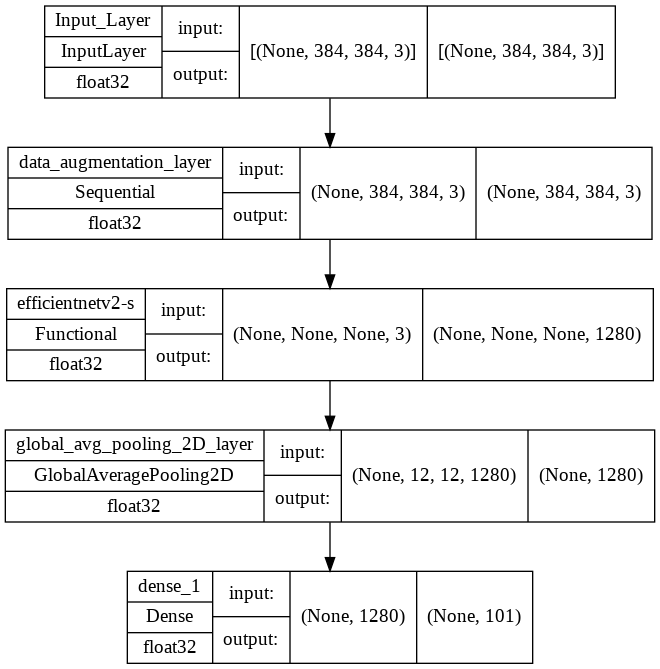

In [27]:
# Model Visualization
plot_model(model_2, show_shapes = True, show_dtype = True, show_layer_names = True)

In [28]:
# Model training
checkpoint_path = "/content/drive/MyDrive/tfexperiments/model_2_checkpoints/model_2.ckpt"
model_2.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), # Default learning rate
                metrics = ["accuracy"])

history_101_model_2_augmented = model_2.fit(train_data,
                                  epochs = 20,
                                  steps_per_epoch = len(train_data),
                                  validation_data = valid_data,
                                  validation_steps = len(valid_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "/content/drive/MyDrive/tfexperiments/training_logs",
                                                                           experiment_name = "efficientnetV2S_all_aug_data_model_2"),
                                               model_checkpoints, early_callback])

Saving Tensorboard log files to: /content/drive/MyDrive/tfexperiments/training_logs/efficientnetV2S_all_aug_data_model_2/20220814-063918
Epoch 1/20
2368/2368 [==============================] - ETA: 0s - loss: 1.8488 - accuracy: 0.5471
Epoch 1: val_accuracy did not improve from 0.78875
2368/2368 [==============================] - 933s 387ms/step - loss: 1.8488 - accuracy: 0.5471 - val_loss: 1.1135 - val_accuracy: 0.7005
Epoch 2/20
2368/2368 [==============================] - ETA: 0s - loss: 1.3742 - accuracy: 0.6457
Epoch 2: val_accuracy did not improve from 0.78875
2368/2368 [==============================] - 740s 312ms/step - loss: 1.3742 - accuracy: 0.6457 - val_loss: 1.0044 - val_accuracy: 0.7233
Epoch 3/20
2368/2368 [==============================] - ETA: 0s - loss: 1.2676 - accuracy: 0.6698
Epoch 3: val_accuracy did not improve from 0.78875
2368/2368 [==============================] - 694s 292ms/step - loss: 1.2676 - accuracy: 0.6698 - val_loss: 0.9453 - val_accuracy: 0.7380
Epoch

### Results

Augmenting the data has resulted on average in a marginally higher validation loss and a lower validation accuracy. Despite this training loss and validation loss did not converge in till the last 20th epoch and the highest validation accuracy was 77.47%. This means that we can increase the training epochs for the model and the validation might increase albeit at a slower rate. 

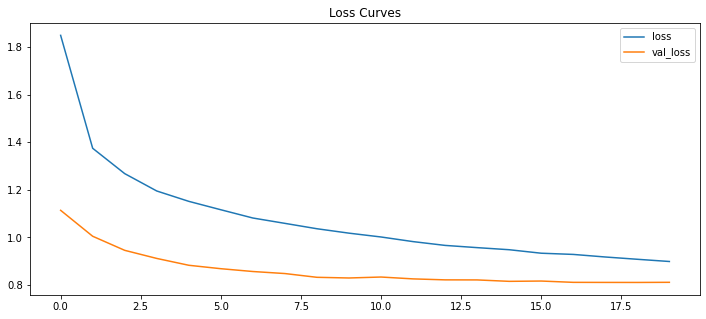

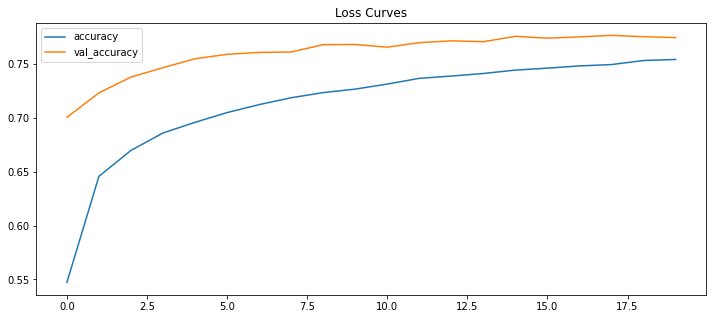

In [29]:
# Results visualization 
pd.DataFrame(history_101_model_2_augmented.history)[["loss", "val_loss"]].plot(figsize = (12,5), title = "Loss Curves")
pd.DataFrame(history_101_model_2_augmented.history)[["accuracy", "val_accuracy"]].plot(figsize = (12,5), title = "Loss Curves")
plt.show()

### Model-2 Fine tuning 

As mentioned before the model was trained on ImageNet and the parameters except the output layer were representative of the ImageNet dataset. The reason to connect a custom fully connected dense (output) layer is that we can adjust the models parameters to our own classes by applying back propogation during training. This is in summary is feature extraction transfer learning. But we can fine tune the model after it has been trained with the custom classes. This can be done by unfreezing/training some of the layers in the base model (EfficientNetV2S) and training the same model an additional number of epochs. 

Unfreezing the number of layers depends on many factors and one of the main factors is size of the training data. If training data is large a larger number of layers can be unfrozen at once. Despite this a good practice is to start by unfreezing a smaller number of layers to avoid overfitting and then incrementally increase after each training. Validation metrics need to be monitored at each step of the training. 

One key note to know is that when unfreezing layers the learning rate of the  optimizer needs to be reduced. The reason is that due to unfreezing there would be more trainable paramaters. To reach a lower training loss these parameters would be adjusted significantly and resultingly the model would start to become overfit. To avoid this we can reduce the learning rate during fine tuning as the learning rate is directly proportional to the step size. In general terms step size is the leap the model takes in adjusing the paramaters during each epoch. Common practice is to reduce the learning 10x each time additional layers are unfrozen.

In [30]:
# Unfreezed all of the layers in base model
base_model_2.trainable = True

# Refreezed every layer except last 5 layers
for layers in base_model_2.layers[:-5]:
  layers.trainable = False

In [31]:
# Recompile the model which needs to be done everytime we change the layers paramters or change the learning rate
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), # LR lowered by 10x
                loss = tf.keras.losses.sparse_categorical_crossentropy,
                metrics = ["accuracy"])

❗Only things that are trainable are base model and output layer. Tensorflow represents the Input and Augmentation and GlobalAveragePooling2D layer as trainable but in fact they are not. This is also representated in the next line of code where the all the layers are represented. 

In [32]:
# Trainable layers
for layer in model_2.layers:
  print(layer.name, layer.trainable) 

Input_Layer True
data_augmentation_layer True
efficientnetv2-s True
global_avg_pooling_2D_layer True
dense_1 True


In [33]:
# All layers 
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,  layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_add False
13 block2a_expand_conv False
14 block2a_expand_bn False
15 block2a_expand_activation False
16 block2a_project_conv False
17 block2a_project_bn False
18 block2b_expand_conv False
19 block2b_expand_bn False
20 block2b_expand_activation False
21 block2b_project_conv False
22 block2b_project_bn False
23 block2b_add False
24 block2c_expand_conv False
25 block2c_expand_bn False
26 block2c_expand_activation False
27 block2c_project_conv False
28 block2c_project_bn False
29 block2c_add False
30 block2d_expand_conv False
31 block2d_expand_bn False
32 block2d_expand_activation False
33 block2d_project_conv False
34 block2d_project_bn False
35 block2d_add False
36 block3a_expand_conv

In [34]:
# Model training
checkpoint_path = "/content/drive/MyDrive/tfexperiments/model_2_finetuned_checkpoints/model_2_finetuned.ckpt"
print(f"Starting Epoch{history_101_model_2_augmented.epoch[-1]}")
history_101_model_2_augmented_fine_tuned = model_2.fit(train_data,
                                  epochs = 40,
                                  steps_per_epoch = len(train_data),
                                  validation_data = valid_data,
                                  validation_steps = len(valid_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "/content/drive/MyDrive/tfexperiments/training_logs",
                                                                           experiment_name = "efficientnetV2S_all_aug_data_model_2_fine_tuned"),
                                               model_checkpoints, early_callback],
                                  initial_epoch = history_101_model_2_augmented.epoch[-1])

Starting Epoch19
Saving Tensorboard log files to: /content/drive/MyDrive/tfexperiments/training_logs/efficientnetV2S_all_aug_data_model_2_fine_tuned/20220814-101922
Epoch 20/40
2368/2368 [==============================] - ETA: 0s - loss: 0.8506 - accuracy: 0.7666
Epoch 20: val_accuracy improved from 0.78875 to 0.78911, saving model to /content/drive/MyDrive/tfexperiments/model_checkpoints/model_1.ckpt
2368/2368 [==============================] - 654s 269ms/step - loss: 0.8506 - accuracy: 0.7666 - val_loss: 0.7497 - val_accuracy: 0.7891
Epoch 21/40
2368/2368 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.7859
Epoch 21: val_accuracy improved from 0.78911 to 0.79640, saving model to /content/drive/MyDrive/tfexperiments/model_checkpoints/model_1.ckpt
2368/2368 [==============================] - 634s 267ms/step - loss: 0.7731 - accuracy: 0.7859 - val_loss: 0.7289 - val_accuracy: 0.7964
Epoch 22/40
2368/2368 [==============================] - ETA: 0s - loss: 0.7203 -

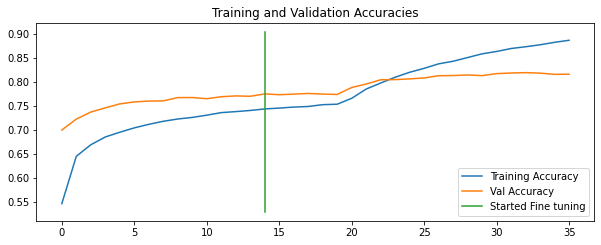

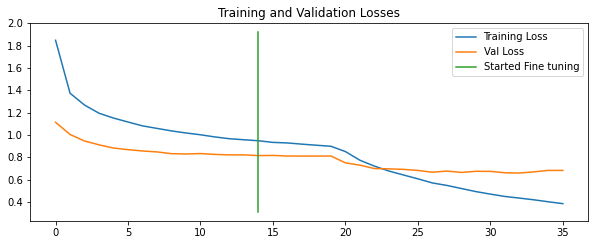

In [35]:
# Visualization for comparison
def compare_history(original_history, new_history, initial_epochs = 5):
  """
  Compares the histories of two models by utiling tensorflow objects
  """

  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history 
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize= (10,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs - 1, initial_epochs -1], plt.ylim(), label = "Started Fine tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracies")

  # Make plot for loss
  plt.figure(figsize= (10,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs - 1, initial_epochs -1], plt.ylim(), label = "Started Fine tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Losses")

# Compared Feature Extraction and Fine Tuning Model 
compare_history(history_101_model_2_augmented, history_101_model_2_augmented_fine_tuned, initial_epochs = 15)

### Results

Due to fine tuning both training and validation loss saw a steep decline around 20 epoch. This means that the model was able to adjust its parameters more suitable to our custom data. 

After a few epochs despite a lower learning rate training loss started to decline at a increasing rate, While the decline in validation loss although declining was not proporpotional to the traning loss. This divergence again means that the model is starting to overfit. Despite being trained for addtional 20 epochs model stopped training 15 epoch or 35th epoch in general.Model checkpoint has stored the best validation accuracy which is at the 32nd epoch i.e. 82.01%. 

#### Visualizing confusion matrix and metrics evaluation

In [36]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    Confusion matrix plot comparing y_true and y_pred.
  """  
  # Create the confustion matrix
  from sklearn.metrics import confusion_matrix
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools
   
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # (Plot x-axis labels vertically
  plt.xticks(rotation = 90, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [39]:
# Now we get all predcitions classes for all images
pred_classes = pred_probs.argmax(axis = 1)
print(tf.size(pred_probs.argmax(axis = 1)))

# Now we get labels from actual test dataset and compare it to our predictions labels
# To do that we have to unbatch the test dataset and pull out the labels 

y_labels = []

for images, labels in valid_data_test.unbatch():
  y_labels.append(labels.numpy())

# Verification if Unbatched data labels are equal to predicted labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = (y_labels),  y_pred = pred_classes)
sklearn_accuracy

tf.Tensor(25250, shape=(), dtype=int32)


0.8168712871287128

Best practice for a binary or multiclass classfication model is to evaluate the performance metrics by utlizing the confusion matrix. Not only it helps is evaluating the Accuracy (True Postives/True Negatives) but also the Precision and Recall. 

The confusion matrix is representing the Accuracy of about 81.6%. Meaning out of 25250 images, 20604 have been predicted correctly. We can also visualize the confusion of the model in each class and which classes the model is getting the most confused in. 

It is interesting to see in the confusion matrix the correlation between the classes and wrong predictions. Most of the food classes the model have predicted wrongly are somewhat similar to one another. Similarity can be in terms of their shapes and colors. E.g. One of the most noticiable is class of Steak which the model keeps predicting as Filet Mignon, Pork Chops and Prime Ribs. This can be due to the fact that all these have very similar shapes and color. Another confusion that is being caused is between Carrot Cake and Strawberry shortcake. Might be that the model is confusing the shapes and thinking of these items to be the same. 

There are several remedies to solve this issue but will be discussed after generating further insights below.

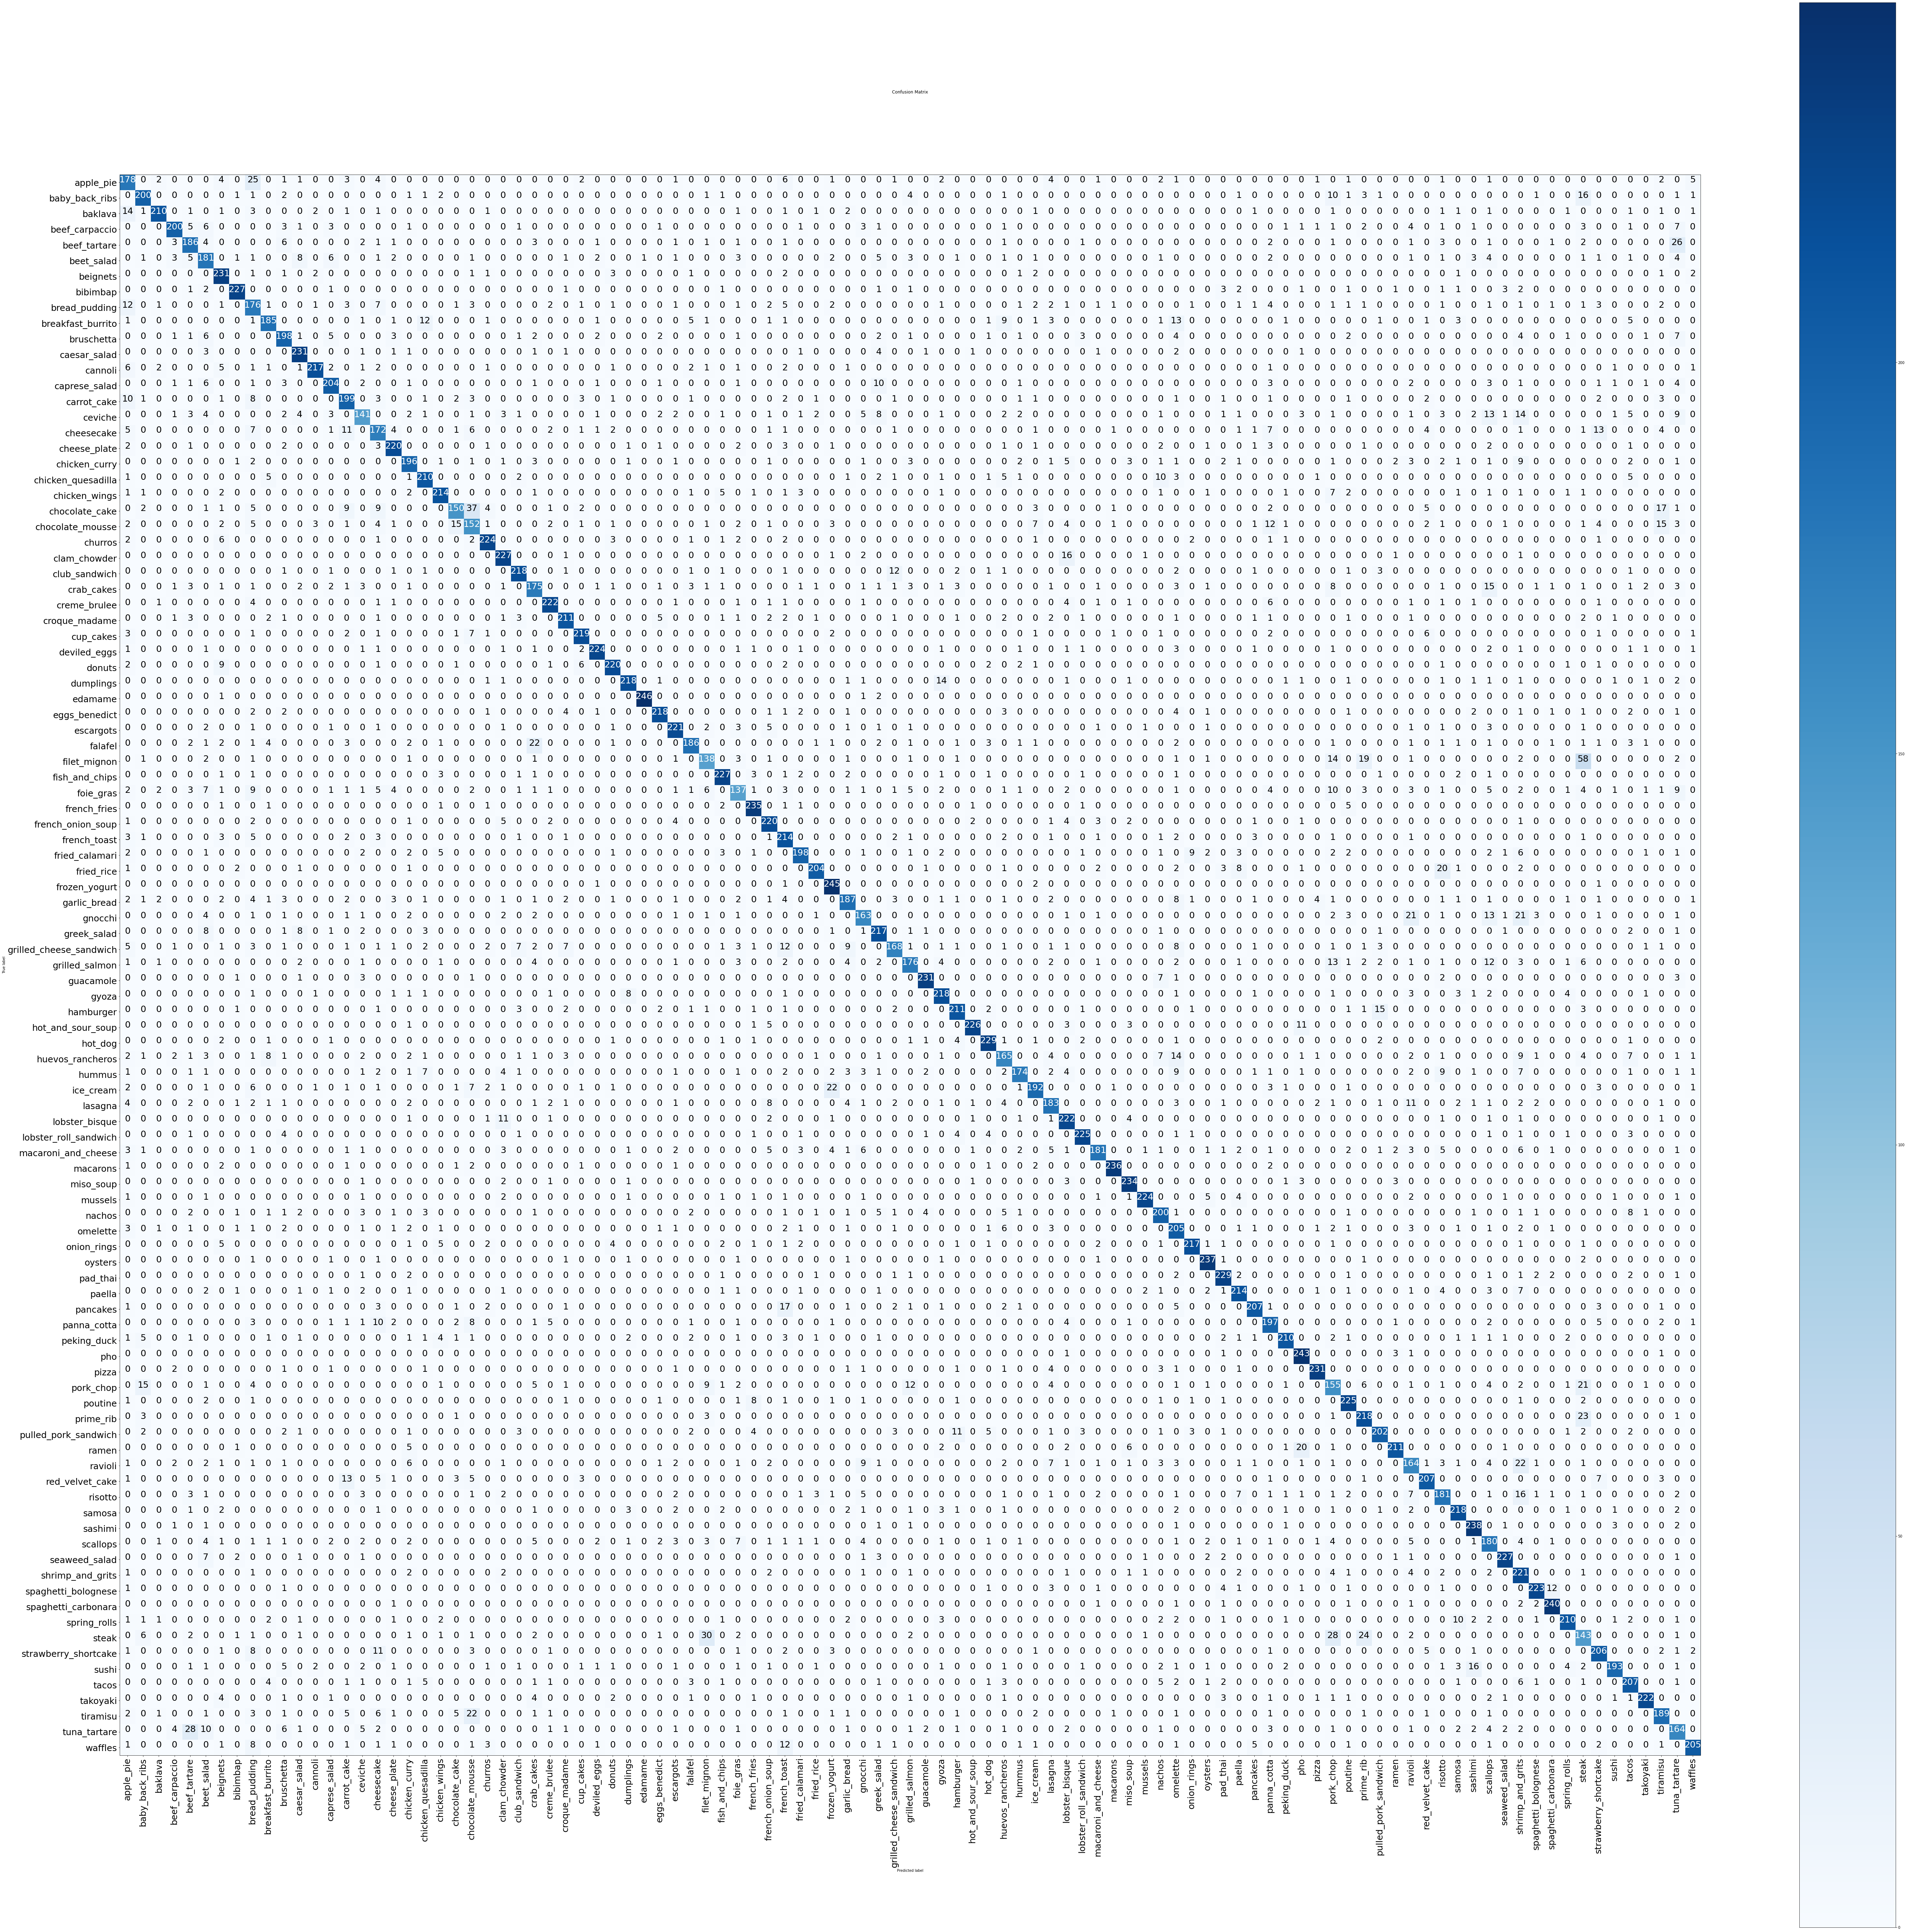

In [40]:
make_confusion_matrix(y_true = y_labels, 
                      y_pred = pred_classes, 
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 25)

In [41]:
# Different metrics to evaluate classficiation matrix 

from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels, y_pred = pred_classes, target_names = class_names))

                         precision    recall  f1-score   support

              apple_pie       0.62      0.71      0.66       250
         baby_back_ribs       0.82      0.80      0.81       250
                baklava       0.93      0.84      0.88       250
         beef_carpaccio       0.90      0.80      0.85       250
           beef_tartare       0.72      0.74      0.73       250
             beet_salad       0.65      0.72      0.69       250
               beignets       0.78      0.92      0.85       250
               bibimbap       0.94      0.91      0.92       250
          bread_pudding       0.56      0.70      0.62       250
      breakfast_burrito       0.84      0.74      0.79       250
             bruschetta       0.77      0.79      0.78       250
           caesar_salad       0.86      0.92      0.89       250
                cannoli       0.95      0.87      0.91       250
          caprese_salad       0.85      0.82      0.83       250
            carrot_cake 

F1 score is a good evaluation metric for a combination of Precision and Recall for a large number of classes. The best F1 score for a particular class that can be achievable is 1 while the worst F1 score is 0.

To visualize the F1 score we can extract the F1 score from the Pandas dataframe and create a barchart to see which classses have the best or worst F1 score.

In [ ]:
# Lets visualize 
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)

# Empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items 
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1_scores to new dictionary
    class_f1_scores[valid_data_test.class_names[int(k)]] = v["f1-score"]
class_f1_scores

# Turn this into a dataframe for visualization 
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)

In [44]:
# Visualize F1 Score 
f1_scores

class_names  f1-score
33              edamame  0.989940
63             macarons  0.957404
91  spaghetti_carbonara  0.935673
51            guacamole  0.935223
54    hot_and_sour_soup  0.933884
..                  ...       ...
8         bread_pudding  0.620811
37         filet_mignon  0.614699
22     chocolate_mousse  0.586873
77            pork_chop  0.582707
93                steak  0.512545

[101 rows x 2 columns]

It is quite evident from the barchart that classes which are more similar to one another result in a lower F1 score. This is similar to the confusion matrix. Food classes like Edamame and Macrons which are very disimilar to other food types have a higher F1 score. This means that the model is able to ascertain the features maps of these images more clearly. 

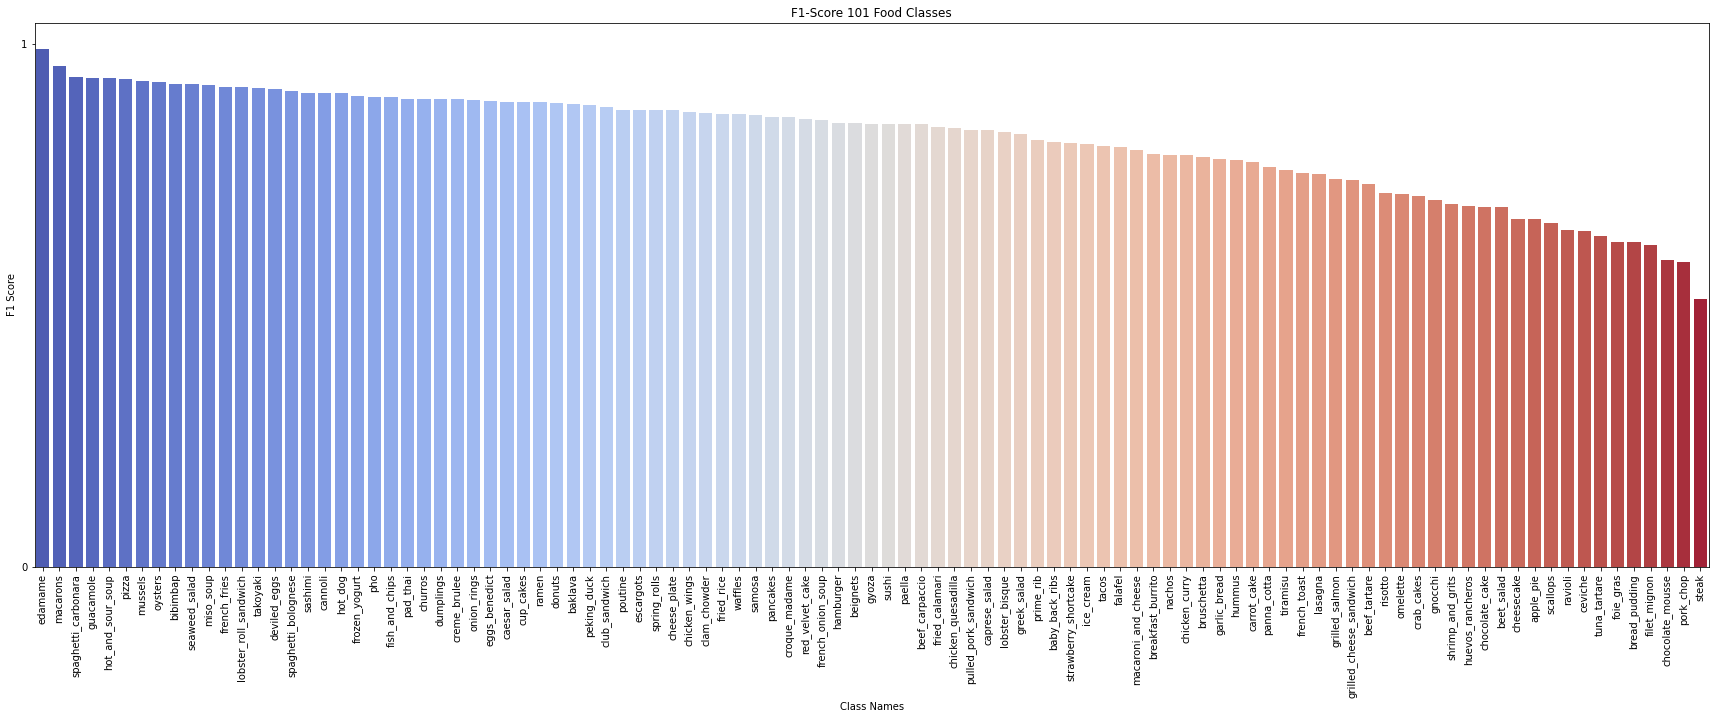

In [45]:
# Barchart
from seaborn import barplot
import matplotlib
plt.figure(figsize= (30,10))
plt.title("F1-Score 101 Food Classes")
plt.yticks(range(len(f1_scores[["f1-score"]])))
plt.xticks(rotation = 90)
matplotlib.axes.Axes.invert_yaxis
ax = barplot(data = f1_scores, y = "f1-score", x = "class_names", palette = "coolwarm")
ax.set(xlabel="Class Names", ylabel="F1 Score")
plt.show()

In [48]:
# File path for all images
filepaths = []
for filepath in valid_data_test.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

# Dataframe for the test images

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                       "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis = 1), # get the maximum pred prob value for an image
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]}) 

# Which preictions in our dataframe which predcitions are most wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

# In new dataframe where prediction is wrong and has softmax probability

wrong_predictions = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)

wrong_predictions[:1000]

img_path  y_true  y_pred  \
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
10690  b'101_food_classes_10_percent/test/french_toas...      42       6   
14542  b'101_food_classes_10_percent/test/ice_cream/1...      58      45   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
3509   b'101_food_classes_10_percent/test/carrot_cake...      14      29   

       pred_conf y_true_classname y_pred_classname  pred_correct  
16271   0.999997          mussels          oysters         False  
10690   0.999964     french_toast         beignets         False  
14542   0.999961        ice_cream    frozen_yogurt         False  
18001   0.999956         pancakes         omelette         False  
3509    0.999871      carrot_cake        cup_cakes         False

Remedies
---

Another way to evaluate is to extract the array of the prediction probabilites for each image and looking at those outputs where the model is confident in its prediction (high probability) for a certain class but is wrong. This can give us further insight in which class is the model predicting wrong and getting the most confused.


By looking at the confusion matrix and the visualization of the images below following remedies can be done to further improve the training of the model. 

 1. Improving image samples:- As seen in the most earliest visualization of the sample data many images are irrelavant, e.g. the image of an hotdog was represented as a hotdog stand. The data in these type of images is unreprentative and will certianly reduce the accuracy of the model. There is also a certain amount of noise in the data e.g some images contain humans and utensils. These can be removed from training in order to improve results as well. 
 2. Merging classes: As seen from the confusion matrix and the F1 scores similar model is confusing classes of foods which are most similar to one another. To avoid this we can either merge certain classes of foods e.g. cakes and create a new label or perhaps for a certain class with the lowest F1 score more training images can be provided so the model is able to learn the features in a more accurate way.
 3. Improve labelling:- Sometimes contrary to thinking the model is right but there is human error. As we can see in the visualization below the model has predicted one of the pictures to be a cupcake with a probability of 99.95%. On the first look any human visualizing that image will say that it is a cupcake. The model cannot be blamed. In the dataset itself there are several images which have been labelled wrongly. The CNN model has been able to learn the features of the cup cake well but due to incorrect labelling we see the prediction lowering the accuract of the overall model.



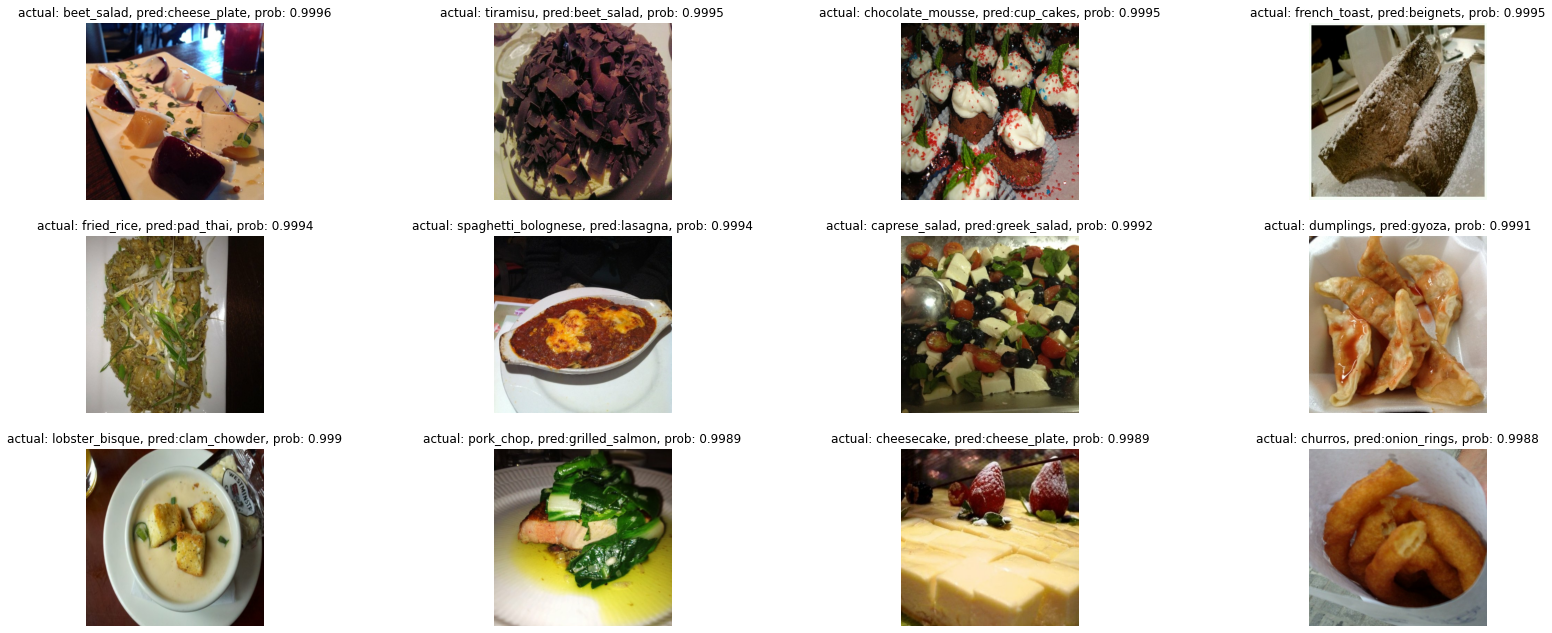

In [49]:
# Visualize the test data samples which have wrong predcitions but have the highest prediction probabilities

images_to_view = 12
start_index = 12
plt.figure(figsize = (28,15))
for i, row in enumerate(wrong_predictions[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(4,4,i+1)
  img = load_and_preprocess_image(row[1], scale = True, img_shape= 384)
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname, _ = row 
  plt.imshow(img)
  plt.title(f"actual: {y_true_classname}, pred:{y_pred_classname}, prob: {round(pred_prob, ndigits=4)}")
  plt.axis(False)